In [3]:
from astropy import table
import numpy as np
from pathlib import Path
from scipy import stats
import betterplotlib as bpl

bpl.set_style()

In [4]:
def get_all_catalogs(catalog_prefix):
    tables = []
    data_dir = Path("../data").resolve()
    for galaxy_dir in data_dir.iterdir():
        size_dir = galaxy_dir / "size"
        for file in size_dir.iterdir():
            if catalog_prefix in file.name and file.suffix == ".h5":
                new_table = table.Table.read(file, format="hdf5")
                new_table["galaxy"] = galaxy_dir.name
                tables.append(new_table)
    return tables

In [6]:
cats_old = get_all_catalogs("radialweighting3pix_abs_bgscale1e3_thetascale1e2_noaprior_noqprior_multiplestarts")
cats_new = get_all_catalogs("radialweighting3pix_abs_bgscale1e3_nopriorsatall_multiplestarts_luminosity_powell")

In [7]:
big_table_old = table.vstack(cats_old, join_type="inner")
big_table_new = table.vstack(cats_new, join_type="inner")

In [21]:
def get_mad(big_table):
    std_cols = []
    mad_cols = []
    for col in big_table.colnames:
        if "x0_variations" in col:
            std_col = col.replace("x0_variations", "x0_std")
            mad_col = col.replace("x0_variations", "x0_mad")

            big_table[std_col] = np.std(big_table[col], axis=1)
            big_table[mad_col] = stats.median_abs_deviation(big_table[col], axis=1)

            std_cols.append(std_col)
            mad_cols.append(mad_col)

    std_cols = std_cols[2:]  # throw out full image xy, keep snapshot xy
    mad_cols = mad_cols[2:]  # throw out full image xy, keep snapshot xy
    # throw out luminosity/surface brightnes
    del mad_cols[2]
    
    return mad_cols

In [22]:
mad_cols = get_mad(big_table_old)
mad_cols = get_mad(big_table_new)
# This is just the list of column names

In [26]:
def make_cumulative_histogram(values):
    """
    Create the line to be plotted for a cumulative histogram

    :param values: data
    :return: List of xs and ys to be plotted for the cumulative histogram
    """
    sorted_values = np.sort(values)
    ys = np.arange(1, 1 + len(sorted_values), 1)
    assert len(ys) == len(sorted_values)
    return sorted_values, ys / np.max(ys)

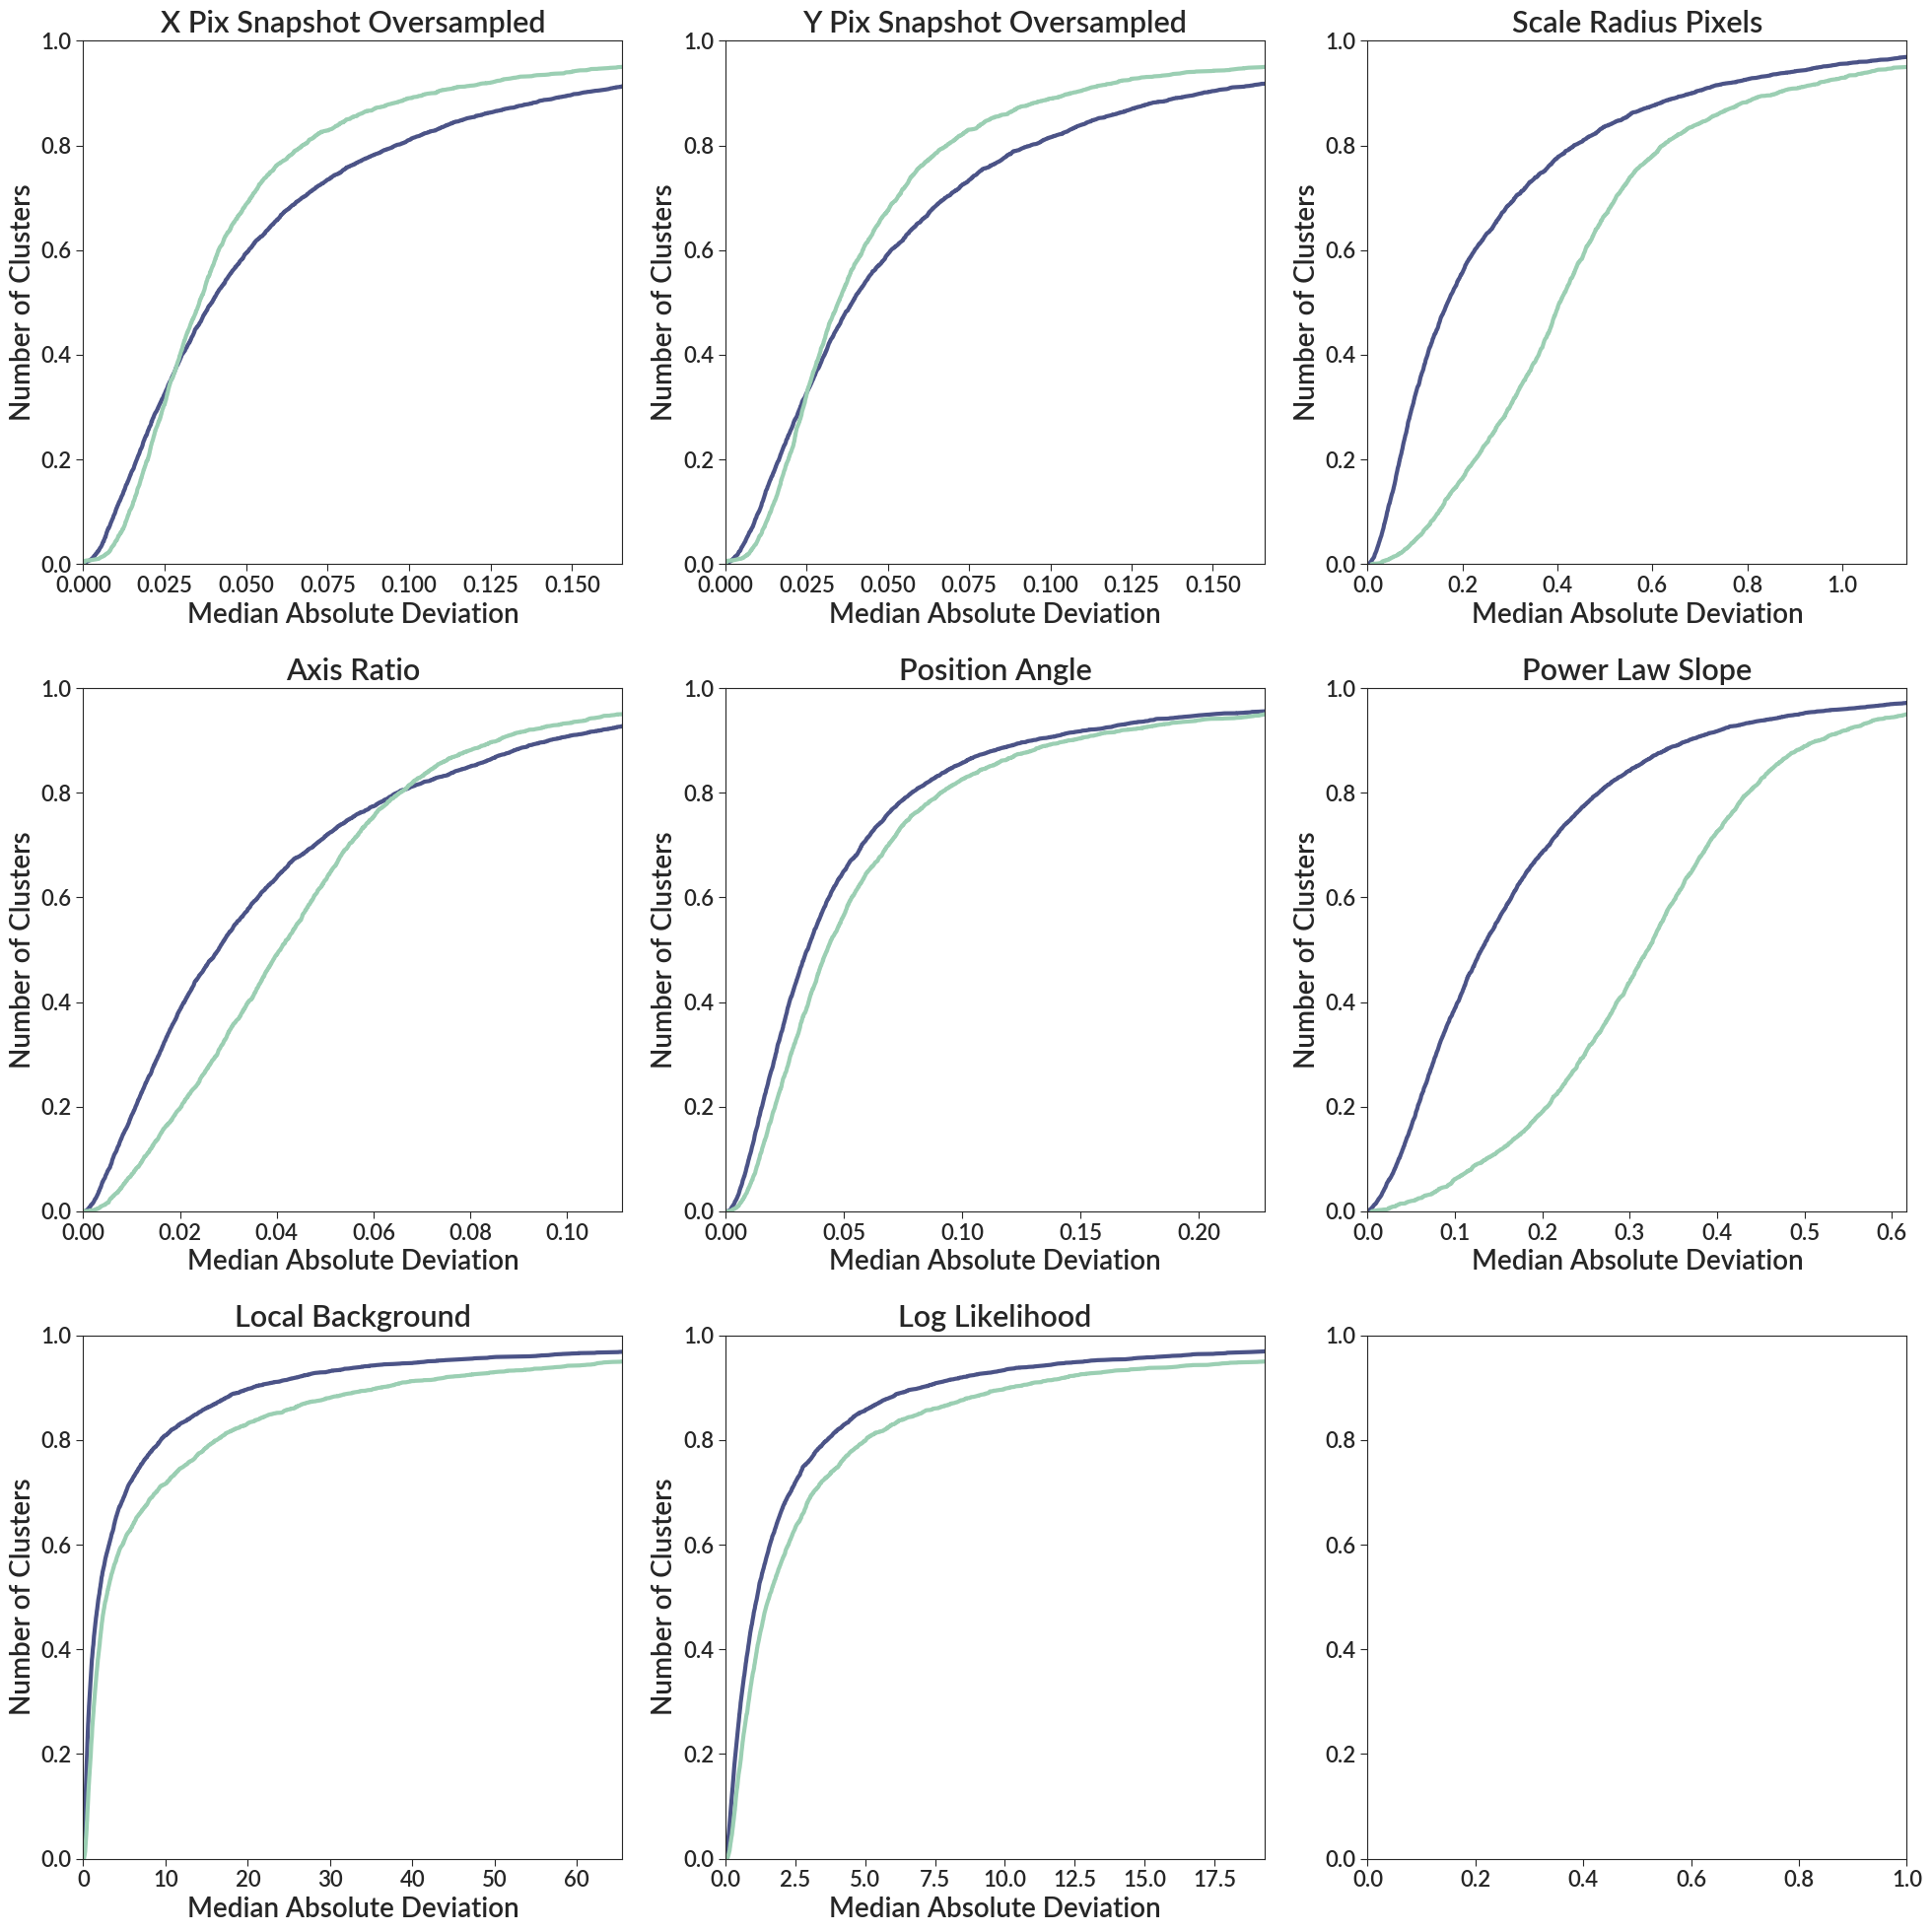

In [74]:
fig, axs = bpl.subplots(ncols=3, nrows=3, figsize=[20, 20])
axs = axs.flatten()
for ax, col in zip(axs, mad_cols):
    data_old = big_table_old[col]
    data_new = big_table_new[col]
    
    ax.plot(*make_cumulative_histogram(data_old), label="Old")
    ax.plot(*make_cumulative_histogram(data_new), label="Old")
    name = col[:-7].replace("_", " ").title()
    ax.add_labels("Median Absolute Deviation", "Number of Clusters", name)
    ax.set_limits(0, np.percentile(data_new, 95), 0, 1)

# Punchline is that things are not convergin

In [141]:
def create_differential_log_likelihoods(big_table):
    full_sort = np.sort(big_table["log_likelihood_x0_variations"].data, axis=1)[:,::-1]

    for i in range(1, len(full_sort[0])):
        big_table[f"delta_log_likelihood_{i}"] = full_sort[:,0] - full_sort[:,i]
        
    # Also make one big row
    big_table[f"delta_log_likelihoods"] =  np.zeros(np.shape(big_table["log_likelihood_x0_variations"]))
    for row in big_table:
        best = np.max(row["log_likelihood_x0_variations"].data)
        row[f"delta_log_likelihoods"] = np.sort(best - row["log_likelihood_x0_variations"])
        



In [142]:
create_differential_log_likelihoods(big_table_old)
create_differential_log_likelihoods(big_table_new)

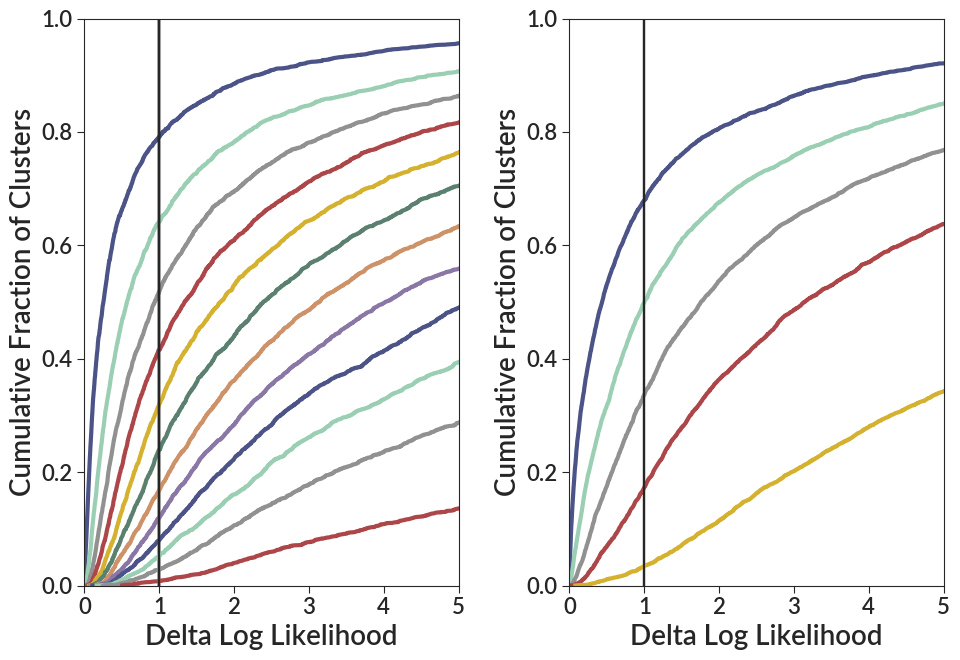

In [143]:
fig, axs = bpl.subplots(ncols=2)
for i in range(1, 13):
    axs[0].plot(*make_cumulative_histogram(big_table_new[f"delta_log_likelihood_{i}"]))
    axs[0].axvline(1)
for i in range(1, 6):
    axs[1].plot(*make_cumulative_histogram(big_table_old[f"delta_log_likelihood_{i}"]))
    axs[1].axvline(1)

for ax in axs:
    ax.set_limits(0, 5, 0, 1)
    ax.add_labels("Delta Log Likelihood", "Cumulative Fraction of Clusters")

# Look at ones that are having the biggest issues

In [200]:
for row in big_table_new:
    if row["log_likelihood_x0_mad"] > 10:
#         print("\n\n\n===============")
        print(row["galaxy"], row["ID"])
#         for col in big_table_new.colnames:
#             if "x0_variations" in col:
#                 print(col, row[col])

ngc6503 322
ngc6503 1382
ngc6503 1469
ngc6503 1831
ngc6503 2342
ngc6503 2531
ngc6503 2751
ngc6503 3833
ngc6503 3900
ngc6503 3949
ugc4459 173
ugc4459 190
ugc4459 860
ngc3738 251
ngc3738 307
ngc3738 428
ngc3738 447
ngc3738 448
ngc3738 494
ngc3738 506
ngc3738 588
ngc3738 591
ngc3738 592
ngc3738 613
ngc3738 651
ngc3738 677
ngc3738 690
ngc3738 818
ngc3738 911
ngc3738 994
ngc3738 1017
ngc3738 1019
ngc3738 1233
ngc3738 1285
ngc3738 1300
ngc3738 1426
ngc1433 131
ngc1433 425
ngc1433 433
ngc1433 495
ngc1433 496
ngc1433 654
ngc1433 659
ngc1433 951
ugca281 100
ugca281 103
ugca281 150
ngc5253 1
ngc5253 99
ngc5253 310
ngc5253 595
ngc5253 600
ngc5253 605
ngc5253 606
ngc5253 610
ngc5253 615
ngc5253 653
ngc5253 672
ngc5253 685
ngc5253 864
ngc5253 931
ngc5253 1003
ngc5253 1077
ngc5253 1255
ngc5253 1298
ngc5253 1302
ngc5253 1330
ngc5253 1805
ngc5253 2057
ugc685 54
ugc685 87
ngc5238 428
ngc5238 591
ngc5474 2376
ngc7793-w 413
ngc7793-w 553
ngc7793-w 623
ngc7793-w 740
ngc7793-w 922
ngc7793-w 1109
ngc7793-w 

# compare the uncertainties in r_Eff

In [82]:
# ======================================================================================
#
# Define some functions defining various quantities
#
# ======================================================================================
def logistic(eta):
    """
    This is the fit to the slopes as a function of eta

    These slopes are used in the ellipticity correction.
    :param eta: Eta (power law slope)
    :return: The slope to go in ellipticity_correction
    """
    ymax = 0.57902801
    scale = 0.2664717
    eta_0 = 0.92404378
    offset = 0.07298404
    return ymax / (1 + np.exp((eta_0 - eta) / scale)) - offset


def ellipticy_correction(q, eta):
    """
    Correction for ellipticity. This given R_eff(q) / R_eff(q=1)

    This is a generalized form of the simplified form used in Ryon's analysis. It's
    simply a line of arbitrary slope passing through (q=1, correction=1) as circular
    clusters need no correction. This lets us write the correction in point slope form
    as:
    y - 1 = m (q - 1)
    y = 1 + m (q - 1)

    Note that when m = 0.5, this simplifies to y = (1 + q) * 0.5, as used in Ryon.
    The slope here (m) is determined by fitting it as a function of eta.
    """
    return 1 + logistic(eta) * (q - 1)


def eff_profile_r_eff_with_rmax(eta, a, q, rmax):
    """
    Calculate the effective radius of an EFF profile, assuming a maximum radius.

    :param eta: Power law slope of the EFF profile
    :param a: Scale radius of the EFF profile, in any units.
    :param q: Axis ratio of the profile
    :param rmax: Maximum radius for the profile, in the same units as a.
    :return: Effective radius, in the same units as a and rmax
    """
    # This is such an ugly formula, put it in a few steps
    term_1 = 1 + (1 + (rmax / a) ** 2) ** (1 - eta)
    term_2 = (0.5 * (term_1)) ** (1 / (1 - eta)) - 1
    return ellipticy_correction(q, eta) * a * np.sqrt(term_2)

In [85]:
big_table_new["r_eff_variations"] = np.zeros((len(big_table_new), 13))
big_table_new["r_eff_best"] = np.zeros(len(big_table_new))
for row in big_table_new:
    this_reff = []
    for i in range(13):
        a = row["scale_radius_pixels_x0_variations"][i]
        q = row["axis_ratio_x0_variations"][i]
        eta = row["power_law_slope_x0_variations"][i]
        
        this_reff.append(eff_profile_r_eff_with_rmax(eta, a, q, 15))
    row["r_eff_variations"] = np.array(this_reff)
    
    a_best = row["scale_radius_pixels_best"]
    q_best = row["axis_ratio_best"]
    eta_best = row["power_law_slope_best"]
    row["r_eff_best"] = eff_profile_r_eff_with_rmax(eta_best, a_best, q_best, 15)

In [99]:
big_table_new["r_eff_variations_std"] = np.std(big_table_new["r_eff_variations"], axis=1)
big_table_new["r_eff_variations_mad"] = stats.median_abs_deviation(big_table_new["r_eff_variations"], axis=1)

big_table_new["r_eff_variations_frac_std"] = big_table_new["r_eff_variations_std"] / big_table_new["r_eff_best"]
big_table_new["r_eff_variations_frac_mad"] = big_table_new["r_eff_variations_mad"] / big_table_new["r_eff_best"]

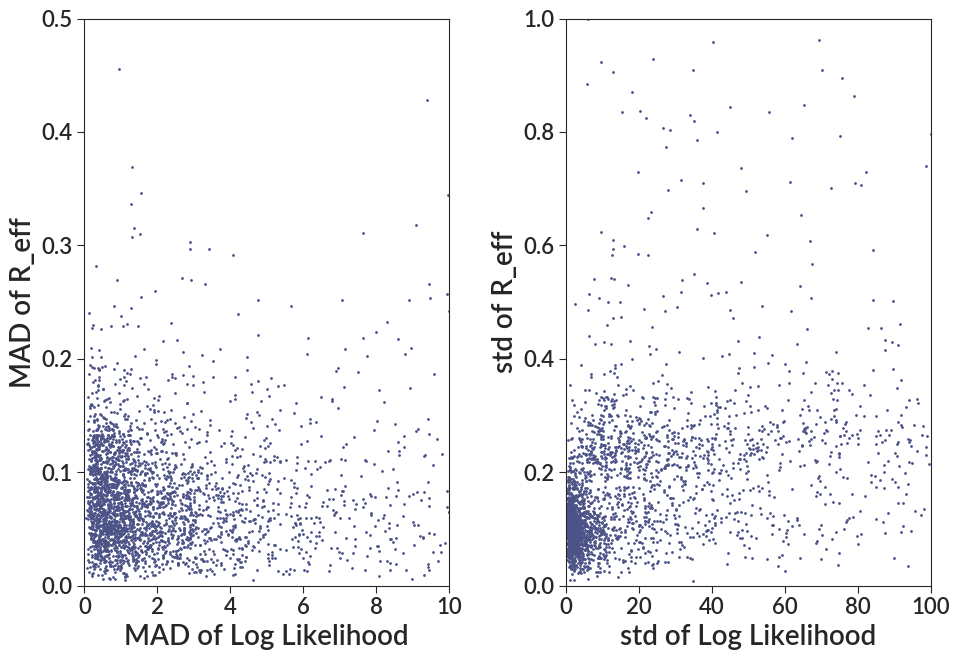

In [109]:
fig, axs = bpl.subplots(ncols=2)
axs[0].scatter(big_table_new["log_likelihood_x0_mad"], big_table_new["r_eff_variations_frac_mad"], 
              alpha=1, s=1)
axs[0].add_labels("MAD of Log Likelihood", "MAD of R_eff")
axs[0].set_limits(0, 10, 0, 0.5)

axs[1].scatter(big_table_new["log_likelihood_x0_std"], big_table_new["r_eff_variations_frac_std"], 
              alpha=1, s=1)
axs[1].add_labels("std of Log Likelihood", "std of R_eff")
axs[1].set_limits(0, 100, 0, 1)

## Do this on a fit by fit basis, rather than MAD

In [212]:
big_table_new["r_eff_variations_diff"] = np.zeros(big_table_new["r_eff_variations"].shape)
for row in big_table_new:
    row["r_eff_variations_diff"] = abs(row["r_eff_variations"] - row["r_eff_best"]) / row["r_eff_best"]
    
big_table_new["log_likihood_variations_frac"] = np.zeros(big_table_new["r_eff_variations"].shape)
for row in big_table_new:
    best = np.max(row["log_likelihood_x0_variations"].data)
    row["log_likihood_variations_frac"] = (row["log_likelihood_x0_variations"] - best) / best

In [176]:
def get_percentiles(xs, ys, percentile, x_min, x_max, dx):
    bins = np.arange(x_min, x_max + 0.5 * dx, dx)

    bin_centers = []
    y_percentiles = []
    for idx in range(len(bins) - 1):
        lower = bins[idx]
        upper = bins[idx + 1]

        # then find all points in this x range
        mask_above = xs > lower
        mask_below = xs < upper
        mask_good = np.logical_and(mask_above, mask_below)

        good_ys = ys[mask_good]
        if len(good_ys) > 0:
            y_percentiles.append(np.percentile(good_ys, percentile))
            # the bin centers will be the mean 
            bin_centers.append(np.mean([lower, upper]))

    return bin_centers, y_percentiles

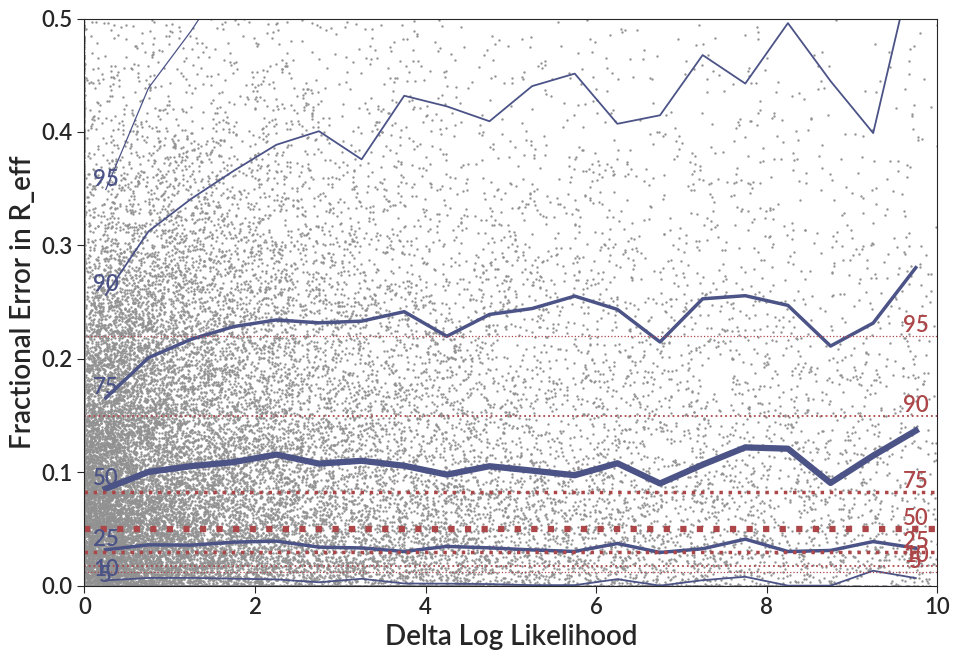

In [192]:
error_levels = [0.01228724, 0.01732308, 0.0297507 , 0.05008462, 0.08292076, 0.14973002, 0.21983486]

fig, ax = bpl.subplots()
xs = big_table_new["delta_log_likelihoods"].data.flatten()
ys = big_table_new["r_eff_variations_diff"].data.flatten()
# ax.hist2d(big_table_new["delta_log_likelihoods"].flatten(),
#                   big_table_new["r_eff_variations_diff"].flatten(),
#                   bins=(np.arange(0, 10.01, 0.5), np.arange(0, 1.01, 0.1)))
ax.scatter(xs, ys,
          s=0.5, alpha=1, c=bpl.color_cycle[2])
ax.set_limits(0, 10, 0, 0.5)

for err_level, percentile in zip(error_levels, [5, 10, 25, 50, 75, 90, 95]):
    x_bins, y_percentile = get_percentiles(
        xs, ys, percentile, 0, 10, 0.5
    )
    ax.plot(
        x_bins,
        y_percentile,
        lw=4 * (1 - (abs(percentile - 50) / 50)) + 0.5,
        zorder=1,
        c=bpl.color_cycle[0]
    )
    ax.text(
        x=x_bins[0],
        y=y_percentile[0],
        ha="center",
        va="bottom",
        s=percentile,
        fontsize=16,
        c=bpl.color_cycle[0]
    )
    
    ax.axhline(err_level, lw=4 * (1 - (abs(percentile - 50) / 50)) + 0.5, 
               ls=":", c=bpl.color_cycle[3])
    ax.text(
        x=x_bins[-1],
        y=err_level,
        ha="center",
        va="bottom",
        s=percentile,
        fontsize=16,
        c=bpl.color_cycle[3]
    )
ax.add_labels("Delta Log Likelihood", "Fractional Error in R_eff")

# go field by field

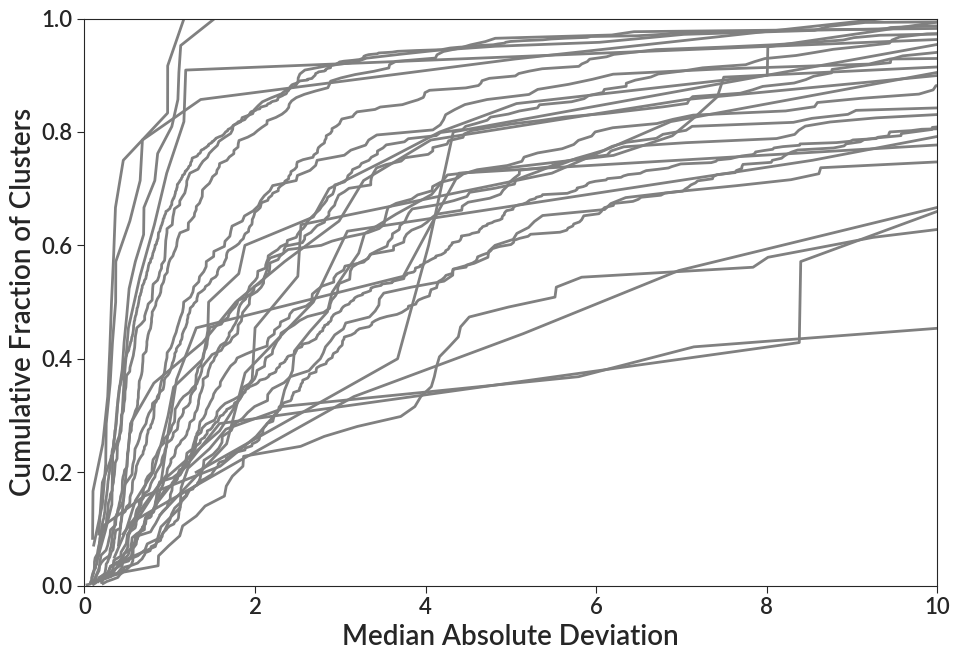

In [199]:
galaxies = np.unique(big_table_new["galaxy"])
fig, ax = bpl.subplots()

for gal in galaxies:
    gal_idx = np.where(big_table_new["galaxy"] == gal)

    data_new = big_table_new["log_likelihood_x0_mad"][gal_idx]
    
    ax.plot(*make_cumulative_histogram(data_new), lw=2, c="0.5")
ax.set_limits(0, 10, 0, 1)
ax.add_labels("Median Absolute Deviation", "Cumulative Fraction of Clusters")

# Try fractional delta log likelihoods

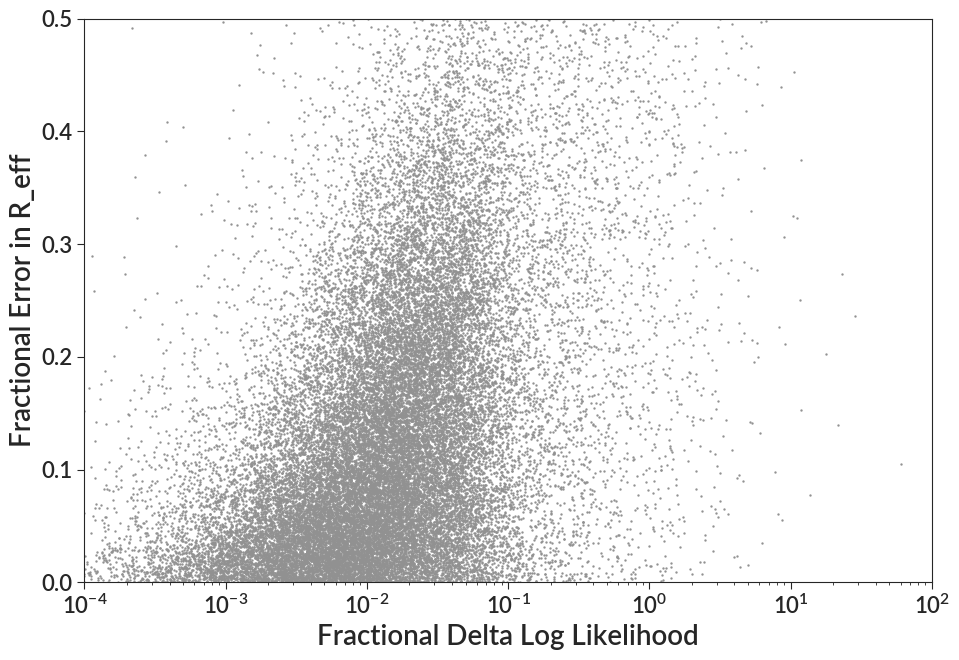

In [224]:
error_levels = [0.01228724, 0.01732308, 0.0297507 , 0.05008462, 0.08292076, 0.14973002, 0.21983486]

fig, ax = bpl.subplots()
xs = big_table_new["log_likihood_variations_frac"].data.flatten() 
ys = big_table_new["r_eff_variations_diff"].data.flatten()
# ax.hist2d(big_table_new["delta_log_likelihoods"].flatten(),
#                   big_table_new["r_eff_variations_diff"].flatten(),
#                   bins=(np.arange(0, 10.01, 0.5), np.arange(0, 1.01, 0.1)))
ax.scatter(xs, ys,
          s=0.5, alpha=1, c=bpl.color_cycle[2])
ax.set_xscale("log")
ax.set_limits(0.0001, 100, 0, 0.5)


ax.add_labels("Fractional Delta Log Likelihood", "Fractional Error in R_eff")

# compare $\chi^2$ between runs